In [1]:
import pandas as pd

# Load the dataset
file_path = "C:/Users/54321/OneDrive/Documents/Desktop/Unified Intern/Climate Change Project/climate_nasa.csv"
climate_data = pd.read_csv(file_path)

# Check for missing values
print("Missing Values:\n", climate_data.isnull().sum())


Missing Values:
 date               0
likesCount         0
profileName        0
commentsCount    278
text              18
dtype: int64


In [2]:
# Handle missing values:
# Fill missing 'commentsCount' with median value
climate_data['commentsCount'] = climate_data['commentsCount'].fillna(climate_data['commentsCount'].median())

# Drop rows where 'text' column is missing (important for sentiment analysis)
climate_data = climate_data.dropna(subset=['text'])

# Reset the index after handling missing values
climate_data.reset_index(drop=True, inplace=True)

# Verify if missing values are handled
print("Missing Values After Handling:\n", climate_data.isnull().sum())


Missing Values After Handling:
 date             0
likesCount       0
profileName      0
commentsCount    0
text             0
dtype: int64


In [3]:
# Feature Engineering: Creating new features based on the 'text' and engagement columns

# Create new feature: text length (number of characters in the comment)
climate_data['text_length'] = climate_data['text'].apply(len)

# Create new feature: word count (number of words in the comment)
climate_data['word_count'] = climate_data['text'].apply(lambda x: len(x.split()))

# Create new feature: likes per comment (normalized likes per comment)
climate_data['likes_per_comment'] = climate_data['likesCount'] / (climate_data['commentsCount'] + 1)  # Avoid division by zero

# Create new feature: month and year from the 'date' column (to analyze time-based trends)
climate_data['year'] = pd.to_datetime(climate_data['date']).dt.year
climate_data['month'] = pd.to_datetime(climate_data['date']).dt.month

# Display the first few rows to check the new features
print(climate_data[['text_length', 'word_count', 'likes_per_comment', 'year', 'month']].head())


   text_length  word_count  likes_per_comment  year  month
0          173          32           0.333333  2022      9
1           51           8           0.000000  2022      9
2          108          16           0.250000  2022      9
3           94          19           0.666667  2022      9
4          128          24           0.592593  2022      9


In [7]:
# Create the sentiment column manually (this is a simple example, modify as needed)
# 1 = Positive, 0 = Negative, 2 = Neutral
climate_data['sentiment'] = climate_data['text'].apply(lambda x: 1 if 'good' in x else (0 if 'bad' in x else 2))

# Display the first few rows to confirm that the sentiment column has been added
print(climate_data[['text', 'sentiment']].head())


                                                text  sentiment
0  Neat comparison I have not heard it before.\n ...          2
1  An excellent way to visualise the invisible! T...          2
2  Does the CO2/ghg in the troposphere affect the...          2
3  excellent post! I defo feel the difference - o...          2
4  Yes, and carbon dioxide does not harm the Eart...          2


In [8]:
from sklearn.model_selection import train_test_split

# Select features (X) and target variable (y)
X = climate_data[['text', 'likesCount', 'commentsCount', 'text_length', 'word_count', 'likes_per_comment']]
y = climate_data['sentiment']  # Now the 'sentiment' column exists

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the training and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (403, 6)
Test set shape: (101, 6)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Apply TF-IDF vectorizer to the 'text' column in the training and test data
X_train_tfidf = vectorizer.fit_transform(X_train['text'])
X_test_tfidf = vectorizer.transform(X_test['text'])

# Check the shape of the transformed data
print("Shape of training data (TF-IDF):", X_train_tfidf.shape)
print("Shape of test data (TF-IDF):", X_test_tfidf.shape)


Shape of training data (TF-IDF): (403, 1000)
Shape of test data (TF-IDF): (101, 1000)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train a Logistic Regression model with balanced class weights
model = LogisticRegression(max_iter=200, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))  # Avoid precision warnings
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9702970297029703
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       0.50      1.00      0.67         1
           2       0.98      0.99      0.98        98

    accuracy                           0.97       101
   macro avg       0.83      0.66      0.55       101
weighted avg       0.98      0.97      0.96       101

Confusion Matrix:
 [[ 0  0  2]
 [ 0  1  0]
 [ 0  1 97]]


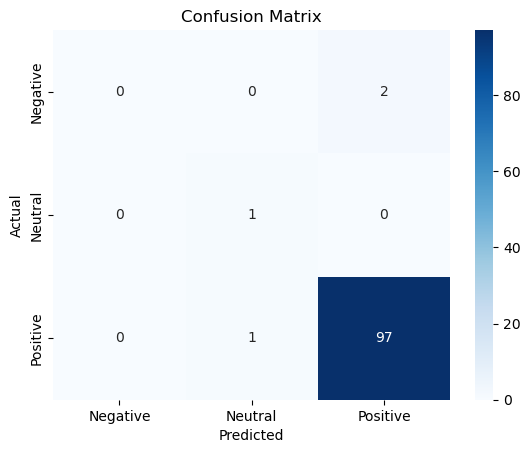

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to try
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_tfidf, y_train)

# Best parameters from the grid search
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# Train the model using the best parameters
best_model = grid_search.best_estimator_

# Predict on the test set with the best model
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found by GridSearchCV: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
Accuracy: 0.9702970297029703
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       0.50      1.00      0.67         1
           2       0.98      0.99      0.98        98

    accuracy                           0.97       101
   macro avg       0.83      0.66      0.55       101
weighted avg       0.98      0.97      0.96       101

Confusion Matrix:
 [[ 0  0  2]
 [ 0  1  0]
 [ 0  1 97]]


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       0.50      1.00      0.67         1
           2       0.98      0.99      0.98        98

    accuracy                           0.97       101
   macro avg       0.83      0.66      0.55       101
weighted avg       0.98      0.97      0.96       101

Confusion Matrix:
 [[ 0  0  2]
 [ 0  1  0]
 [ 0  1 97]]


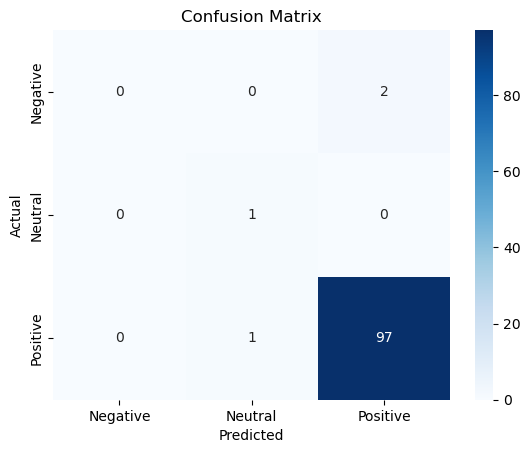

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model using classification report
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

# Confusion matrix to visualize the performance
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix as a heatmap for better visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Check the distribution of classes in the target variable (sentiment)
print("Class distribution in the training set:", y_train.value_counts())
print("Class distribution in the test set:", y_test.value_counts())


Class distribution in the training set: sentiment
2    386
1     10
0      7
Name: count, dtype: int64
Class distribution in the test set: sentiment
2    98
0     2
1     1
Name: count, dtype: int64


In [15]:
import joblib

# Save the trained model
joblib.dump(best_model, 'sentiment_model.pkl')

# Load the saved model (when you want to use it in the future)
loaded_model = joblib.load('sentiment_model.pkl')

# Predict on new data using the loaded model
new_data = ["The climate change is a serious issue and requires immediate attention."]
new_data_tfidf = vectorizer.transform(new_data)
prediction = loaded_model.predict(new_data_tfidf)
print("Sentiment Prediction:", prediction)


Sentiment Prediction: [2]


In [17]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_text = vectorizer.fit_transform(climate_data['text'])

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # You can change n_components for the number of topics
lda.fit(X_text)

# Display the topics
for index, topic in enumerate(lda.components_):
    print(f"Topic {index + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])  # Top 10 words for each topic
    print("\n")


Topic 1:
['make', 'world', 'data', 'just', 'earth', 'planet', 'nasa', 'people', 'change', 'climate']


Topic 2:
['temperature', 'just', 'climate', 'weather', 'know', 'science', 'anos', 'going', 'don', 'global']


Topic 3:
['co2', 'rise', 'years', 'feet', 'level', 'sea', 'atmosphere', 'dioxide', 'water', 'carbon']


Topic 4:
['change', 'climate', 'time', 'atmosphere', 'just', 'heat', 'years', 'sun', 'co2', 'earth']


Topic 5:
['better', 'year', 'planet', 'human', 'energy', 'change', 'climate', 'need', 'warming', 'global']




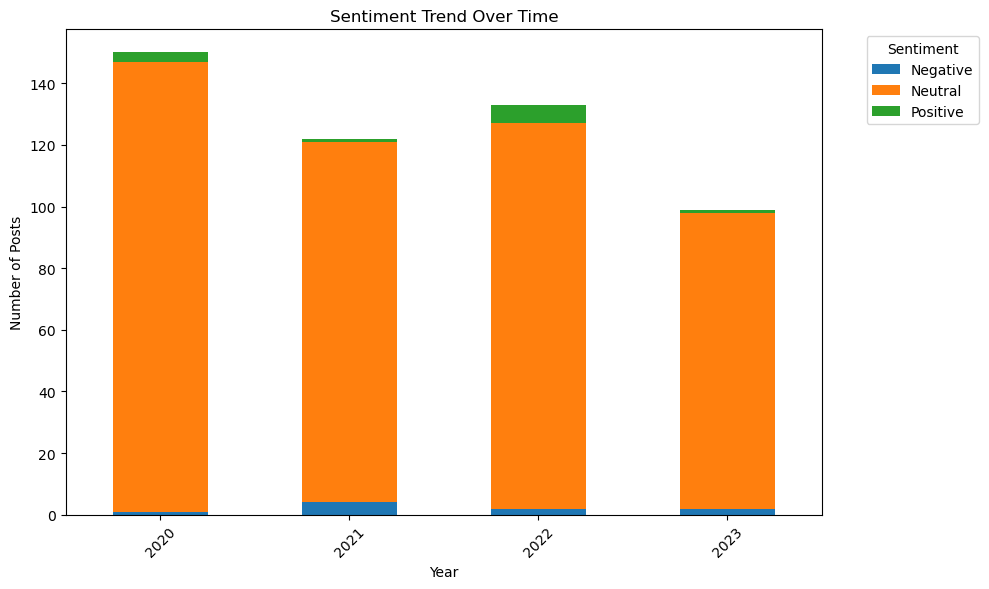

In [18]:
import matplotlib.pyplot as plt

# Add a column for the sentiment label (for better visualization in trends)
climate_data['sentiment_label'] = climate_data['sentiment'].map({0: 'Negative', 1: 'Positive', 2: 'Neutral'})

# Group by year and sentiment to count occurrences
sentiment_trend = climate_data.groupby(['year', 'sentiment_label']).size().unstack(fill_value=0)

# Plot the sentiment trend over the years
sentiment_trend.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Trend Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Select features for predicting engagement
X_engagement = climate_data[['text_length', 'word_count', 'likes_per_comment', 'sentiment']]
y_engagement = climate_data['likesCount']  # You can also try 'commentsCount'

# Split the data into training and test sets
X_train_engagement, X_test_engagement, y_train_engagement, y_test_engagement = train_test_split(X_engagement, y_engagement, test_size=0.2, random_state=42)

# Train the Random Forest model
engagement_model = RandomForestRegressor(n_estimators=100, random_state=42)
engagement_model.fit(X_train_engagement, y_train_engagement)

# Predict engagement on the test set
y_pred_engagement = engagement_model.predict(X_test_engagement)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test_engagement, y_pred_engagement))
print("Mean Squared Error:", mean_squared_error(y_test_engagement, y_pred_engagement))
print("R-squared:", r2_score(y_test_engagement, y_pred_engagement))


Mean Absolute Error: 3.3408910891089105
Mean Squared Error: 158.67786831683168
R-squared: 0.3393624703693786


In [21]:
# Check the column names to see if 'CO2_level' exists
print(climate_data.columns)


Index(['date', 'likesCount', 'profileName', 'commentsCount', 'text',
       'text_length', 'word_count', 'likes_per_comment', 'year', 'month',
       'sentiment', 'sentiment_label'],
      dtype='object')


Missing Values:
 date               0
likesCount         0
profileName        0
commentsCount    278
text              18
dtype: int64
                                                text  sentiment
0  Neat comparison I have not heard it before.\n ...          2
1  An excellent way to visualise the invisible! T...          2
2  Does the CO2/ghg in the troposphere affect the...          2
3  excellent post! I defo feel the difference - o...          2
4  Yes, and carbon dioxide does not harm the Eart...          2
Accuracy:               precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       0.50      1.00      0.67         1
           2       0.98      0.99      0.98        98

    accuracy                           0.97       101
   macro avg       0.83      0.66      0.55       101
weighted avg       0.98      0.97      0.96       101



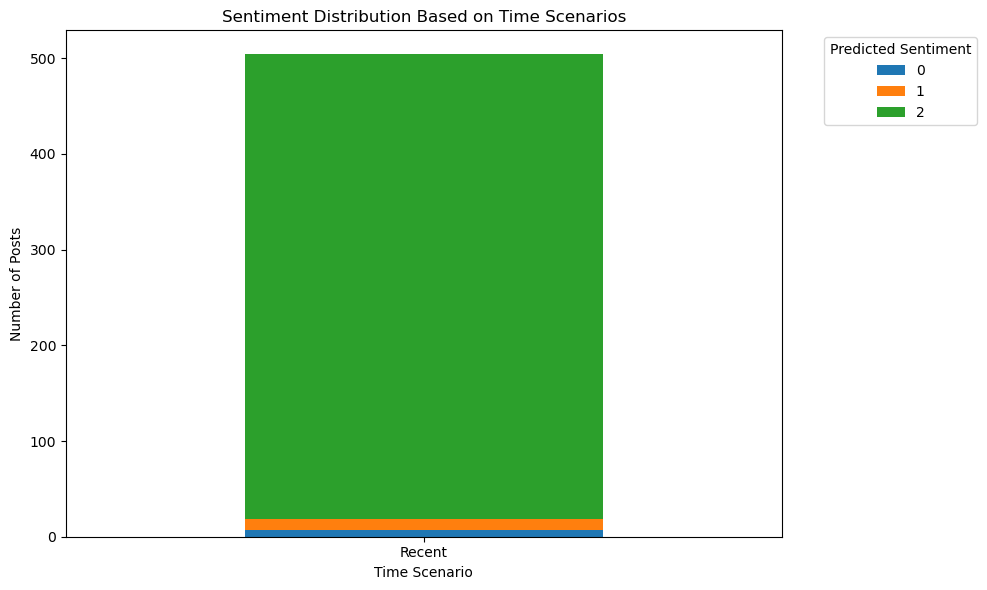

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
file_path = "C:/Users/54321/OneDrive/Documents/Desktop/Unified Intern/Climate Change Project/climate_nasa.csv"
climate_data = pd.read_csv(file_path)

# Check for missing values
print("Missing Values:\n", climate_data.isnull().sum())

# Handle missing values:
# Fill missing 'commentsCount' with median value
climate_data['commentsCount'] = climate_data['commentsCount'].fillna(climate_data['commentsCount'].median())

# Drop rows where 'text' column is missing (important for sentiment analysis)
climate_data = climate_data.dropna(subset=['text'])

# Reset the index after handling missing values
climate_data.reset_index(drop=True, inplace=True)

# Feature Engineering: Creating new features based on the 'text' and engagement columns
climate_data['text_length'] = climate_data['text'].apply(len)
climate_data['word_count'] = climate_data['text'].apply(lambda x: len(x.split()))
climate_data['likes_per_comment'] = climate_data['likesCount'] / (climate_data['commentsCount'] + 1)
climate_data['year'] = pd.to_datetime(climate_data['date']).dt.year
climate_data['month'] = pd.to_datetime(climate_data['date']).dt.month

# Create the sentiment column manually (this is a simple example, modify as needed)
climate_data['sentiment'] = climate_data['text'].apply(lambda x: 1 if 'good' in x else (0 if 'bad' in x else 2))

# Display the first few rows to confirm that the sentiment column has been added
print(climate_data[['text', 'sentiment']].head())

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Apply TF-IDF vectorizer to the 'text' column in the data
X = climate_data[['text', 'likesCount', 'commentsCount', 'text_length', 'word_count', 'likes_per_comment']]
y = climate_data['sentiment']  # Sentiment as target

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply TF-IDF transformation to the 'text' column
X_train_tfidf = vectorizer.fit_transform(X_train['text'])
X_test_tfidf = vectorizer.transform(X_test['text'])

# Train a Logistic Regression model with balanced class weights
model = LogisticRegression(max_iter=200, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

# Predict sentiment for the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", classification_report(y_test, y_pred, zero_division=1))

# Create a new dataframe for scenario analysis
scenario_data = climate_data.copy()

# Define scenarios for years (you can modify this to fit your scenario)
scenario_data['time_scenario'] = scenario_data['year'].apply(
    lambda x: 'Early' if x < 2000 else ('Mid' if 2000 <= x < 2010 else 'Recent')
)

# Apply TF-IDF transformation to the 'text' column for the scenario data
X_scenario_tfidf = vectorizer.transform(scenario_data['text'])

# Predict sentiment for different scenarios
sentiment_predictions = model.predict(X_scenario_tfidf)

# Add the predicted sentiment to the scenario data
scenario_data['predicted_sentiment'] = sentiment_predictions

# Group the data by 'time_scenario' and 'predicted_sentiment', and count occurrences
sentiment_by_time = scenario_data.groupby(['time_scenario', 'predicted_sentiment']).size().unstack(fill_value=0)

# Plot the sentiment distribution based on time scenarios
sentiment_by_time.plot(kind='bar', stacked=True, figsize=(10, 6))

# Title and axis labels
plt.title('Sentiment Distribution Based on Time Scenarios')
plt.xlabel('Time Scenario')
plt.ylabel('Number of Posts')

# Rotate x-axis labels to 0 degrees (straight angle)
plt.xticks(rotation=0)

# Legend and layout adjustments
plt.legend(title='Predicted Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()


In [16]:
# Example: Predict sentiment on new comments
new_comments = [
    "Global warming is a major concern that needs immediate action.",
    "The weather seems fine today, no worries about climate change."
]

# Apply TF-IDF transformation on the new data
new_comments_tfidf = vectorizer.transform(new_comments)

# Predict sentiment
predictions = best_model.predict(new_comments_tfidf)
print("Predictions:", predictions)


Predictions: [2 2]
